# Impacto de la computación en los bienes raices

El proposito de esta investigacion es evaluar como los avances en la computacion en la ultimas decadas han impactado en las ventas e inversion de bienes raices.

Para evaluar el impacto en una determinada industria, se buscara si es posible encontrar correlaciones y posteriormente, si es posible proyectar regresiones lineales, polinomicas o lineales multiples, de poder realizarse estas regresiones, el coeficiente de estas nos indicara cuanto peso ha tenido una determinada tecnologia sobre la industria seleccionada.

## Metodologia

### Busqueda de los datasets

Se realizo una busqueda de datasets que contengan registros de productos relacionados a la computacion, se encontraron en total unos 6 datasets obtenidos de [wikipedia - cantidad de transistores](https://en.wikipedia.org/wiki/Transistor_count) usando [wikitable2csv.ggor.de](https://wikitable2csv.ggor.de/) para extraer las siguientes tablas de datos:
- Memorias Flash.
- FPGA.
- GPU.
- Microprocesadores.
- RAM.
- ROM.

Tambien del [worldbank.org](https://data.worldbank.org/) se obtuvo los siguientes 3 datasets:
- Porcentaje de la poblacion con internet.
- Poblacion (puede ser de utilidad para normalizar aunque no se llego con el plazo para aplicarlo).
- GDP (puede ser de utilidad para hacer comparaciones aunque no se llego con el plazo para aplicarlo).

Los datasets utilizados para las industrias fueron:
- Ventas de bienes raices (el cual fue completamente analizado) fue obtenido de [catalog.data.gov/dataset/real-estate-sales-2001-2018](https://catalog.data.gov/dataset/real-estate-sales-2001-2018), aunque en la url indique ventas desde el 2001 hasta 2018, en realidad contiene registros hasta el 2020.

### Limpieza de los datos

Los datos obtenidos de Wikipedia originalmente tenian monton de irregularidades que son propias de las tablas de esta plataforma, como celdas con referencias a otras paginas, fechas de lanzamiento con formatos inconsistentes, numeros flotantes escritos con commas. Todas estas irregularidades tuvieron que ser eliminadas para poder realizar un posterior analisis.

Por otro lado los datos obtenidos del World Bank Data, como Internet, Poblacion y GDP, poseian como columnas los años y un registro por cada pais, para limpiar estos datasets, primero se filtro el pais de interes y luego se transpuso la tabla para que los valores anuales esten en filas.

Una vez limpios estos datasets relacionados a la computacion, se procedieron a unificar en uno solo fusionados por año.

### Analisis exploratorio

Lo primero que se hizo para empezar el analisis fue fusionar los datasets de las industrias que nos interesan, en este caso bienes_raices + computacion.

Luego este dataset fusionado se utilizo para ver si podemos observar correlaciones entre sus columnas mediante un mapa de calor y luego una grafica de pares (pairplot).

### Proyeccion de regresiones

Mediante el analisis explotario previo, se procedio a seleccionar un par de las tantas correlaciones encontradas y luego se proyectaron regresiones lineales y polinomicas, tambien se utilizo regresiones lineales multiples para saber con que coeficiente impacto cada una de las tecnologias.

### Diagrama resumen de los pasos llevados a cabo
![flow](./docs/steps.svg)

### Dependencias

In [339]:
# Standard packages
import pandas as pd
import numpy as np
import re

# Installed packages
from IPython.display import display
from matplotlib import pyplot as plt
%pip install seaborn
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import SVR

# Local packages
# NOTE:
#   Evitaremos tener que usar modulos locales externos a
#   este notebook de Jupiter para facilitar el uso en la
#   plataforma Google Colab.

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Parametros constantes que utilizaremos

In [340]:
# Constantes
COLUMNA_FECHA = 'Año'
FECHA_MIN = 2001
FECHA_MAX = 2020
DATASETS_FOLDER = './content'
# Utilizaremos esta para indicar si queremos
# guardar el postprocesado de un dataset,
# util si el dataset original es muy pesado.
GUARDAR_DATOS_PROCESADOS = False

# Global state
poblacion = None # Usado para normalizar los datos

### Procesando datos relacionados a la industria de la computacion

Como se menciono anteriormente, se procedera a limpiar, extraer las columnas revelantes y fusionar los datasets de `microprocesadores`, `flash`, `fpga`, `gpus`, `ram`, `rom` e `internet`.

Los pasos llevados a cabo durante esta etapa para limpiar los datos de los multiples datasets, provenientes de Wikipedia, por lo general seran:
1. eliminar columnas innecesarias.
1. extraer el año y guardarlo en una columna 'fecha', no tratamos directamente la fecha ya que pueden estar presente de manera inconsistente, sin seguir un formato especifico.
1. remover comas de los numeros flotantes.
1. convertir a flotante las columnas string que representan numeros.
1. filtramos los registros que esten entre un rango de años.
1. solo nos quedamos con los mayores valores de cada año en una determinada columna, ya que solo nos interesa el avance de la technologia, es decir, por ejemplo, la mayor cantidad de transistores.
1. eliminamos valores Nan.

Finalmente fusionamos este dataframe a uno mas general por fecha.

In [341]:
# En esta lista vamos a ir agregando los diferentes dataframes
# que mas adelante fusionaremos en uno solo.
computacion_dfs = []

In [342]:
def mantener_columnas(df:pd.DataFrame, columnas:list) -> pd.DataFrame:
    """Mantiene solo las COLUMNAS especificadas en un DF"""
    return df[columnas]

def remover_commas(df:pd.DataFrame, columnas: list) -> pd.DataFrame:
    """Remueve las commas de las COLUMNAS especificadas"""
    for col in columnas:
        df[col] = df[col].str.replace(',', '')
    return df

def convertir_a_flotante(df:pd.DataFrame, columnas:list) -> pd.DataFrame:
    """Convierte las columnas especificadas a flotante"""
    for col in columnas:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def cortar_agregar_fechas(
        df: pd.DataFrame,
        fecha_column:str=COLUMNA_FECHA,
        min_anio:int=FECHA_MIN,
        max_anio:int=FECHA_MAX
        ) -> pd.DataFrame:
    """Corta un dataframe en un intervalo de tiempo MIN_ANIO-MAX_ANIO especificado"""
    # Create a new dataset with months between min and max
    result = pd.DataFrame()
    result[fecha_column] = pd.date_range(f'1/1/{min_anio}', f'1/1/{max_anio}',freq='M')
    result[fecha_column] = result[fecha_column].dt.strftime('%Y-%m-%d')
    result[fecha_column] = pd.to_datetime(result[fecha_column], format='%Y-%m-%d')
    # Merge dataframes
    df[fecha_column] = pd.to_datetime(df[fecha_column], format='%Y-%m-%d')
    result = pd.merge(result, df, on=fecha_column, how='outer')
    # Sort by date
    result = result.sort_values(by=[fecha_column]).reset_index(drop=True)
    #
    result = result.fillna(method='ffill')
    return result

def mantener_mayor_por_fecha(
        df: pd.DataFrame,
        columna_valor:str,
        columna_fecha:str=COLUMNA_FECHA
        ) -> pd.DataFrame:
    """Mantiene solo el valor mas alto por fecha, util cuando queremos ver el
       avance de una technologia, solo nos interesa el valor mas alto"""
    df = df.sort_values(by=[columna_fecha, columna_valor], ascending=False)
    df = df.drop_duplicates(subset=[columna_fecha], keep='first')
    # Back to the original order
    df = df.sort_values(by=[columna_fecha]).reset_index(drop=True)
    return df

def columna_fecha_a_fila(df:pd.DataFrame, pais:str, nueva_columna:str) -> pd.DataFrame:
    """Convierte columnas fecha a fila, filtrando por pais, esto es util para datasets del World Bank Data"""
    # Filter rows by country
    df = df[df['Country Name'] == pais]
    # Remove columns that are not a year
    df = df[df.columns[df.columns.str.contains(r'\d{4}')]]
    # Convert columns to rows
    df = df.melt(id_vars=[], var_name=COLUMNA_FECHA, value_name=nueva_columna)
    return df

def normalizar_con_la_poblacion(df:pd.DataFrame, column:str) -> pd.DataFrame:
    """Normalizamos una COLUMNA de un dataframe DF con la poblacion"""
    return df ## TODO: fix this
    assert poblacion is not None, 'El dataframe Poblacion no fue cargado'
    df[column] = np.divide(df[column], poblacion['US Population']) * 100
    return df

def fusionar_por_fecha(dataframes:list) -> pd.DataFrame:
    """Fusiona los DATAFRAMES por fecha,
       NOTE: todos los dataframes deben tener la misma cantidad de filas"""
    result = pd.DataFrame()
    result[COLUMNA_FECHA] = dataframes[0][COLUMNA_FECHA].unique()
    result[COLUMNA_FECHA] = pd.to_datetime(result[COLUMNA_FECHA], format='%Y-%m-%d')
    # Merge dataframes
    for df in dataframes:
        df[COLUMNA_FECHA] = pd.to_datetime(df[COLUMNA_FECHA], format='%Y-%m-%d')
        df = df.sort_values(by=[COLUMNA_FECHA]).reset_index(drop=True)
        df = df.fillna(method='bfill')
        result = pd.merge(result, df, on=COLUMNA_FECHA, how='outer')
    result = result.sort_values(by=[COLUMNA_FECHA]).reset_index(drop=True)
    result = result.fillna(method='bfill')
    return result

* Memoria Flash

Este dataset presenta las columnas:
- `Chip name`: nombre del chip.
- `Capacity`: capacidad en bits del chip.
- `Flash type`: tipo de memoria flash.
- `FGMOS transistor count`: cantidad de transistores.
- `Date of introduction`: fecha de introduccion.
- `Manufacturer(s)`: fabricante.
- `Process`: tamaño del fabricacion en nm.
- `Area`: area del chip en mm2.
- `Transistor density (tr./mm2)`: dencidad de transistores
- `Ref`: referencia de wikipedia

Solamente nos quedaremos con las columnas "Date of introduction" y "FGMOS transistor count" ya que la cantidad de transistores es una buena manera de medir el avance tecnologico.

In [343]:
flash = pd.read_csv(f'{DATASETS_FOLDER}/flash.csv')
flash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Chip name                    24 non-null     object 
 1   Capacity (bits)              24 non-null     object 
 2   Flash type                   24 non-null     object 
 3   FGMOS transistor count       24 non-null     object 
 4   Date of introduction         24 non-null     object 
 5   Manufacturer(s)              24 non-null     object 
 6   Process                      24 non-null     object 
 7   Area                         24 non-null     object 
 8   Transistor density, tr./mm2  24 non-null     object 
 9   Ref                          0 non-null      float64
dtypes: float64(1), object(9)
memory usage: 2.0+ KB


Memoria Flash: limpieza

In [344]:
flash = mantener_columnas(flash, ['FGMOS transistor count', 'Date of introduction'])
# Como manejar fechas con multiples formatos: https://stackoverflow.com/a/60390740/15648632
# Formatos disponibles: https://docs.python.org/3/library/datetime.html#strftime-and-strptime-format-codes
fechas1 = pd.to_datetime(flash['Date of introduction'], errors='coerce', format='%Y')
fechas2 = pd.to_datetime(flash['Date of introduction'], errors='coerce', format='%B %Y')
flash[COLUMNA_FECHA] = fechas1.fillna(fechas2)
flash = flash.drop(columns=['Date of introduction'])
#
flash = remover_commas(flash, ['FGMOS transistor count'])
flash = convertir_a_flotante(flash, ['FGMOS transistor count'])
flash = mantener_mayor_por_fecha(flash, 'FGMOS transistor count')
flash = cortar_agregar_fechas(flash)
flash = flash.fillna(method='bfill')
computacion_dfs.append(flash)

Memoria Flash: revision de los datos limpiados

,FGMOS transistor count
count,2.480000e+02
mean,3.900531e+11
std,6.340693e+11
min,2.621440e+05
25%,1.717987e+10
50%,2.560000e+11
75%,2.560000e+11
max,5.333333e+12


,Año,FGMOS transistor count
243,2019-09-30,2.048000e+12
244,2019-10-31,2.048000e+12
245,2019-11-30,2.048000e+12
246,2019-12-31,2.048000e+12
247,2022-01-01,5.333333e+12


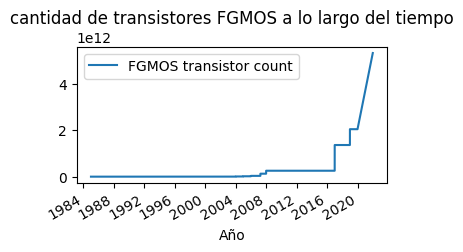

In [345]:
display(flash.describe())
display(flash.tail())
flash.plot(
    x=COLUMNA_FECHA,
    y='FGMOS transistor count',
    title='cantidad de transistores FGMOS a lo largo del tiempo',
    figsize=(4, 2),
    )
plt.show()

* FPGA (matriz de puertas lógicas programable en campo)

Este dataset presenta las columnas:
- `FPGA`: nombre del modelo de FPGA.
- `Transistor count`: cantidad de transistores.
- `Date of introduction`: fecha de introduccion.
- `Designer`: nombre del diseñador.
- `Manufacturer`: nombre del fabricante.
- `Process`: tamaño de la fabricacion en nm.
- `Area`: area en mm2.
- `Transistor density (tr./mm2)`: dencidad de transistores.
- `Ref`: columna de referencia utilizada en Wikipedia.

De todas estas columnas, al igual que con la memoria Flash, luego de la limpieza solo nos quedaremos con la fecha de introduccion y la cantidad de transistores.

In [346]:
fpga = pd.read_csv(f'{DATASETS_FOLDER}/fpga.csv')
fpga.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   FPGA                         16 non-null     object 
 1   Transistor count             16 non-null     object 
 2   Date of introduction         16 non-null     object 
 3   Designer                     16 non-null     object 
 4   Manufacturer                 11 non-null     object 
 5   Process                      13 non-null     object 
 6   Area                         3 non-null      object 
 7   Transistor density, tr./mm2  3 non-null      object 
 8   Ref                          0 non-null      float64
dtypes: float64(1), object(8)
memory usage: 1.2+ KB


FPGA: limpieza de los datos

In [347]:
fpga = mantener_columnas(fpga, ['Transistor count', 'Date of introduction'])
# Pasando cuatrimestres a fecha https://stackoverflow.com/a/53898522/15648632
fechas1 = pd.to_datetime(fpga['Date of introduction'], errors='coerce', format='%Y')
fechas2 = pd.to_datetime(fpga['Date of introduction'], errors='coerce', format='%B %Y')
fechas3 = pd.to_datetime(fpga['Date of introduction'], errors='coerce', format='%Y %?')
fpga[COLUMNA_FECHA] = fechas1.fillna(fechas2).fillna(fechas3)
fpga = fpga.drop(columns=['Date of introduction'])
#
fpga = remover_commas(fpga, ['Transistor count'])
fpga = convertir_a_flotante(fpga, ['Transistor count'])
fpga = fpga.rename(columns={'Transistor count': 'FPGA transistor count'})
fpga = mantener_mayor_por_fecha(fpga, 'FPGA transistor count')
fpga = cortar_agregar_fechas(fpga)
fpga = fpga.fillna(method='bfill')
computacion_dfs.append(fpga)

FPGA: muestreo del dataset limpio

,Año,FPGA transistor count
234,2019-10-31,5.300000e+09
235,2019-11-30,5.300000e+09
236,2019-12-31,5.300000e+09
237,2020-01-01,3.500000e+10
238,2020-01-01,9.200000e+10


,FPGA transistor count
count,2.390000e+02
mean,3.874770e+09
std,6.532048e+09
min,7.000000e+07
25%,1.000000e+09
50%,2.500000e+09
75%,5.300000e+09
max,9.200000e+10


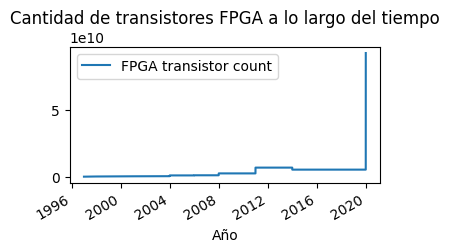

In [348]:
display(fpga.tail())
display(fpga.describe())
fpga.plot(
    x=COLUMNA_FECHA,
    y='FPGA transistor count',
    title='Cantidad de transistores FPGA a lo largo del tiempo',
    figsize=(4, 2),
    )
plt.show()

* GPU (unidad de procesamiento gráfico)

Este dataset presenta las columnas:
- `Processor`: nombre del modelo de procesador.
- `Transistor count`: cantidad de transistores.
- `Year`: año de lanzamiento.
- `Designer(s)`: nombre del diseñador.
- `Fab(s)`: nombre del fabricante.
- `Process`: tamaño de la fabricacion en nm.
- `Area`: area en mm2.
- `Transistor density, (tr./mm2)`: dencidad de transistores.
- `Ref`: columna de referencia utilizada en Wikipedia.

De todas estas columnas, al igual que con los anteriores datasets, luego de la limpieza solo nos quedaremos con el año de lanzamiento y la cantidad de transistores.

In [349]:
gpus = pd.read_csv(f'{DATASETS_FOLDER}/gpus.csv')
gpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163 entries, 0 to 162
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Processor                    163 non-null    object 
 1   Transistor count             163 non-null    object 
 2   Year                         163 non-null    int64  
 3   Designer(s)                  163 non-null    object 
 4   Fab(s)                       163 non-null    object 
 5   Process                      163 non-null    object 
 6   Area                         163 non-null    object 
 7   Transistor density, tr./mm2  163 non-null    object 
 8   Ref                          0 non-null      float64
dtypes: float64(1), int64(1), object(7)
memory usage: 11.6+ KB


GPUs: limpieza del dataset

In [350]:
gpus = mantener_columnas(gpus, ['Transistor count', 'Year'])
# Procesando fecha
gpus[COLUMNA_FECHA] = pd.to_datetime(gpus['Year'], format='%Y')
gpus = gpus.drop(columns=['Year'])
#
gpus = remover_commas(gpus, ['Transistor count'])
gpus = convertir_a_flotante(gpus, ['Transistor count'])
gpus = gpus.rename(columns={'Transistor count': 'GPU transistor count'})
gpus = mantener_mayor_por_fecha(gpus, 'GPU transistor count')
gpus = cortar_agregar_fechas(gpus)
gpus = gpus.fillna(method='bfill')
computacion_dfs.append(gpus)

GPUs: muestreo del dataset limpio

,Año,GPU transistor count
258,2019-12-31,1.030000e+10
259,2020-01-01,5.420000e+10
260,2021-01-01,5.820000e+10
261,2022-01-01,8.000000e+10
262,2023-01-01,1.330000e+10


,GPU transistor count
count,2.630000e+02
mean,6.028366e+09
std,8.969200e+09
min,2.100000e+04
25%,3.210000e+08
50%,3.200000e+09
75%,8.900000e+09
max,8.000000e+10


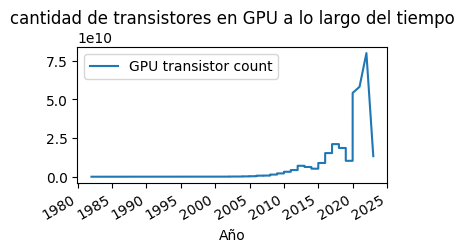

In [351]:
display(gpus.tail())
display(gpus.describe())
gpus.plot(
    x=COLUMNA_FECHA,
    y='GPU transistor count',
    title='cantidad de transistores en GPU a lo largo del tiempo',
    figsize=(4, 2),
    )
plt.show()

* Microprocesador

Este dataset presenta las columnas:
- `Processor`: nombre del modelo de procesador.
- `Transistor count`: cantidad de transistores.
- `Year`: año de lanzamiento.
- `Designer`: nombre del diseñador.
- `Process (nm)`: tamaño de la fabricacion en nm.
- `Area (mm2)`: area en mm2.
- `Transistor density, tr./mm2`: dencidad de transistores.

De todas las columnas solo nos quedaremos con el año de lanzamiento y la cantidad de transistores.

In [352]:
microprocesadores = pd.read_csv(f'{DATASETS_FOLDER}/microprocessors.csv')
microprocesadores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Processor                    234 non-null    object
 1   Transistor count             234 non-null    object
 2   Year                         234 non-null    object
 3   Designer                     234 non-null    object
 4   Process
(nm)                 234 non-null    object
 5   Area (mm2)                   234 non-null    object
 6   Transistor density, tr./mm2  234 non-null    object
dtypes: object(7)
memory usage: 12.9+ KB


Microprocesadores: limpieza del dataset

In [353]:
microprocesadores = mantener_columnas(microprocesadores, ['Transistor count', 'Year'])
#
microprocesadores[COLUMNA_FECHA] = pd.to_datetime(microprocesadores['Year'], errors='coerce', format='%Y')
microprocesadores = microprocesadores.drop(columns=['Year'])
#
microprocesadores = remover_commas(microprocesadores, ['Transistor count'])
microprocesadores = microprocesadores[microprocesadores['Transistor count'].str.contains(r'^\d+$')]
microprocesadores = convertir_a_flotante(microprocesadores, ['Transistor count'])
microprocesadores = microprocesadores.rename(columns={'Transistor count': 'Microprocessor transistor count'})
microprocesadores = mantener_mayor_por_fecha(microprocesadores, 'Microprocessor transistor count')
microprocesadores = cortar_agregar_fechas(microprocesadores)
microprocesadores = microprocesadores.fillna(method='bfill')
computacion_dfs.append(microprocesadores)

Microprocesadores: muestreo del dataset limpio

,Año,Microprocessor transistor count
276,2019-12-31,3.954000e+10
277,2020-01-01,1.600000e+10
278,2021-01-01,5.700000e+10
279,2022-01-01,1.140000e+11
280,2023-01-01,6.700000e+10


,Microprocessor transistor count
count,2.810000e+02
mean,6.185692e+09
std,1.196830e+10
min,2.500000e+03
25%,4.100000e+08
50%,1.900000e+09
75%,5.560000e+09
max,1.140000e+11


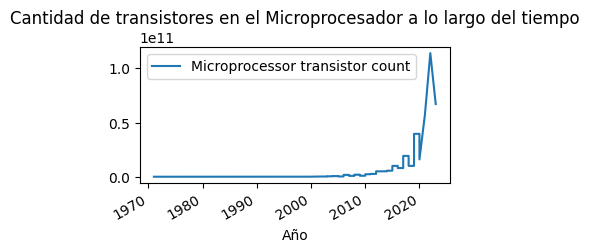

In [354]:
display(microprocesadores.tail())
display(microprocesadores.describe())
microprocesadores.plot(
    x=COLUMNA_FECHA,
    y='Microprocessor transistor count',
    title='Cantidad de transistores en el Microprocesador a lo largo del tiempo',
    figsize=(4, 2),
    )
plt.show()

* RAM (memoria de acceso aleatorio)

Este dataset presenta las columnas:
- `Chip name`: nombre del chip.
- `Capacity (bits)`: capacidad en bits del chip.
- `RAM type`: tipo de memoria RAM.
- `Transistor count`: cantidad de transistores.
- `Date of introduction`: fecha de introduccion.
- `Manufacturer(s)`: fabricante.
- `Process`: tamaño de la fabricacion en nm.
- `Area`: area en mm2.
- `Transistor density, tr./mm2`: dencidad de transistores.
- `Ref`: columna de referencia utilizada en Wikipedia.

De todas las columnas solo nos quedaremos con la fecha de introduccion y la cantidad de transistores.

In [355]:
ram = pd.read_csv(f'{DATASETS_FOLDER}/ram.csv')
ram.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Chip name                    48 non-null     object 
 1   Capacity (bits)              48 non-null     object 
 2   RAM type                     48 non-null     object 
 3   Transistor count             48 non-null     object 
 4   Date of introduction         48 non-null     object 
 5   Manufacturer(s)              48 non-null     object 
 6   Process                      48 non-null     object 
 7   Area                         48 non-null     object 
 8   Transistor density, tr./mm2  48 non-null     object 
 9   Ref                          0 non-null      float64
dtypes: float64(1), object(9)
memory usage: 3.9+ KB


RAM: limpieza del dataset

In [356]:
ram = mantener_columnas(ram, ['Date of introduction', 'Transistor count'])
#
fecha1 = pd.to_datetime(ram['Date of introduction'], errors='coerce', format='%Y')
fecha2 = pd.to_datetime(ram['Date of introduction'], errors='coerce', format='%B %Y')
fecha3 = pd.to_datetime(ram['Date of introduction'], errors='coerce', format='%B %d%, %Y')
ram[COLUMNA_FECHA] = fecha1.fillna(fecha2).fillna(fecha3)
ram = ram.drop(columns=['Date of introduction'])
#
ram = remover_commas(ram, ['Transistor count'])
ram = convertir_a_flotante(ram, ['Transistor count'])
ram = ram.rename(columns={'Transistor count': 'RAM transistor count'})
ram = mantener_mayor_por_fecha(ram, 'RAM transistor count')
ram = cortar_agregar_fechas(ram)
ram = ram.fillna(method='bfill')
# MALO: computacion_dfs.append(ram) este dataset tiene un monton Nan values

RAM: muestreo del dataset limpio

,Año,RAM transistor count
256,2019-09-30,1.374390e+11
257,2019-10-31,1.374390e+11
258,2019-11-30,1.374390e+11
259,2019-12-31,1.374390e+11
260,2019-12-31,1.073742e+09


,RAM transistor count
count,2.610000e+02
mean,2.359537e+10
std,4.077344e+10
min,6.000000e+00
25%,4.294967e+09
50%,8.589935e+09
75%,8.589935e+09
max,1.374390e+11


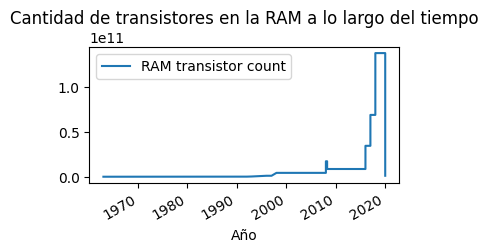

In [357]:
display(ram.tail())
display(ram.describe())
ram.plot(
    x=COLUMNA_FECHA,
    y='RAM transistor count',
    title='Cantidad de transistores en la RAM a lo largo del tiempo',
    figsize=(4, 2),
    )
plt.show()

Luego de ver los datos procesados y limpios de la RAM, se puede llegar a la conclusion de que lo mejor seria descartar este dataset ya que tiene demaciados valores Nan

* ROM (memoria de solo lectura)

Este dataset presenta las columnas:
- `Chip name`: nombre del chip.
- `Capacity (bits)`: capacidad en bits del chip.
- `ROM type`: tipo de memoria ROM.
- `Transistor count`: cantidad de transistores.
- `Date of introduction`: fecha de introduccion.
- `Manufacturer(s)`: fabricante.
- `Process`: tamaño de la fabricacion en nm.
- `Area`: area en mm2.
- `Ref`: columna de referencia utilizada en Wikipedia.

De todas las columnas solo nos quedaremos con la fecha de introduccion y la cantidad de transistores.

In [358]:
rom = pd.read_csv(f'{DATASETS_FOLDER}/rom.csv')
rom.tail()

,Chip name,Capacity (bits),ROM type,Transistor count,Date of introduction,Manufacturer(s),Process,Area,Ref
17,27512,512 Kb,EPROM (HMOS),"524,288",1984,Intel,?,?,NaN
18,?,1 Mb,EPROM (CMOS),"1,048,576",1984,NEC,"1,200 nm",?,NaN
19,?,4 Mb,EPROM (CMOS),"4,194,304",1987,Toshiba,800 nm,?,NaN
20,?,16 Mb,EPROM (CMOS),"16,777,216",1990,NEC,600 nm,?,NaN
21,?,16 Mb,MROM,"16,777,216",1995,"AKM, Hitachi",?,?,NaN


ROM: limpieza del dataset

In [359]:
rom = mantener_columnas(rom, ['Date of introduction', 'Transistor count'])
#
rom[COLUMNA_FECHA] = pd.to_datetime(rom['Date of introduction'], format='%Y')
rom = rom.drop(columns=['Date of introduction'])
#
rom = remover_commas(rom, ['Transistor count'])
rom = convertir_a_flotante(rom, ['Transistor count'])
rom = rom.rename(columns={'Transistor count': 'ROM transistor count'})
rom = mantener_mayor_por_fecha(rom, 'ROM transistor count')
rom = cortar_agregar_fechas(rom)
rom = rom.fillna(method='bfill')
# MALO: computacion_dfs.append(rom) este no tiene suficientes datos validos

ROM: muestreo del dataset limpio

,Año,ROM transistor count
239,2019-08-31,16777216.0
240,2019-09-30,16777216.0
241,2019-10-31,16777216.0
242,2019-11-30,16777216.0
243,2019-12-31,16777216.0


,ROM transistor count
count,2.440000e+02
mean,1.583837e+07
std,3.821991e+06
min,1.024000e+03
25%,1.677722e+07
50%,1.677722e+07
75%,1.677722e+07
max,1.677722e+07


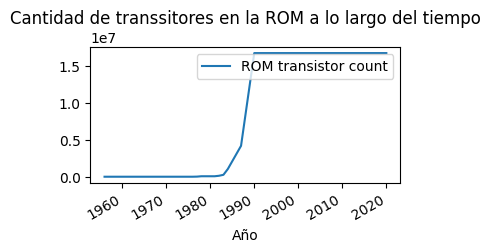

In [360]:
display(rom.tail())
display(rom.describe())
rom.plot(
    x=COLUMNA_FECHA,
    y='ROM transistor count',
    title='Cantidad de transsitores en la ROM a lo largo del tiempo',
    figsize=(4, 2),
    )
plt.show()

Como observamos en el muestreo de datos luego de la limpieza, al igual que con la RAM, vamos a descartar los datos de la ROM ya que faltan demaciados registros desde el 2000 hasta la actualidad.

* Internet

Este dataset presenta las columnas:
- `Country Name`: nombre del pais.
- `Country Code`: codigo ISO del pais.
- `Indicator Name`: nombre del indicador.
- `Indicator Code`: codigo del indicador.
- `1960, 1961, ..., 2023`: porcentajes de internet por año.

Ya que este dataset fue obtenido del World Bank Data y no tiene irregularidades en los datos, los pasos para procesar a este dataset seran diferentes a los demas:
1. filtramos el pais de interes (Estados Unidos).
1. convertimos las columnas de años en filas.
1. agregamos este dataframe a uno mas general, fusionando por fecha.

In [361]:
internet = pd.read_csv(f'{DATASETS_FOLDER}/theworldbank_internet.csv')
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 68 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    266 non-null    object 
 1   Country Code    266 non-null    object 
 2   Indicator Name  266 non-null    object 
 3   Indicator Code  266 non-null    object 
 4   1960            7 non-null      float64
 5   1961            0 non-null      float64
 6   1962            0 non-null      float64
 7   1963            0 non-null      float64
 8   1964            0 non-null      float64
 9   1965            7 non-null      float64
 10  1966            0 non-null      float64
 11  1967            0 non-null      float64
 12  1968            0 non-null      float64
 13  1969            0 non-null      float64
 14  1970            7 non-null      float64
 15  1971            0 non-null      float64
 16  1972            0 non-null      float64
 17  1973            0 non-null      flo

Internet: limpieza del dataset

In [362]:
internet = columna_fecha_a_fila(internet, 'United States', 'US internet percentage')
internet[COLUMNA_FECHA] = pd.to_datetime(internet[COLUMNA_FECHA], format='%Y')
internet = cortar_agregar_fechas(internet)
computacion_dfs.append(internet)

Internet: muestreo del dataset limpio

,Año,US internet percentage
286,2019-11-30,89.430285
287,2019-12-31,89.430285
288,2020-01-01,90.620470
289,2021-01-01,91.753208
290,2022-01-01,91.753208


,US internet percentage
count,261.000000
mean,70.278876
std,15.574419
min,0.784729
25%,67.968053
50%,71.690000
75%,75.000000
max,91.753208


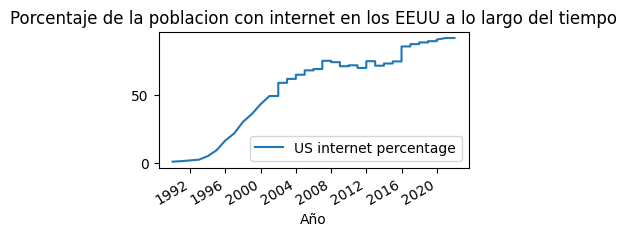

In [363]:
display(internet.tail())
display(internet.describe())
internet.plot(
    x=COLUMNA_FECHA,
    y='US internet percentage',
    title='Porcentaje de la poblacion con internet en los EEUU a lo largo del tiempo',
    figsize=(4, 2),
    )
plt.show()

In [364]:
## TODO: agregar dataset relacionado a los telefonos celular.

In [365]:
## TODO:
##  agregar dataset relacionado al avance de la IA, tengase en cuenta
##  que el avance de las redes neuronales se pueden medir con la cantidad de 
##  capas y neuronas utilizadas, mientras que el avance en transformers puede
##  medirse con la cantidad de parametros utilizados.
##  Otra manera de medir el avance podria ser mediante la cantidad de papers publicados.

In [366]:
## TODO: agregar dataset relacionado a la memoria SSD.

Unificamos todos los datasets limpios relacionados a la computacion en un solo dataframe y revisamos si se realizo correctamente

In [367]:
computer_advances = fusionar_por_fecha(computacion_dfs)
computer_advances.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 6 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Año                              294 non-null    datetime64[ns]
 1   FGMOS transistor count           293 non-null    float64       
 2   FPGA transistor count            291 non-null    float64       
 3   GPU transistor count             294 non-null    float64       
 4   Microprocessor transistor count  294 non-null    float64       
 5   US internet percentage           293 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 13.9 KB


Procederemos a remover los outliers, que podrian afectar al analisis exploratorio y a las regresiones.

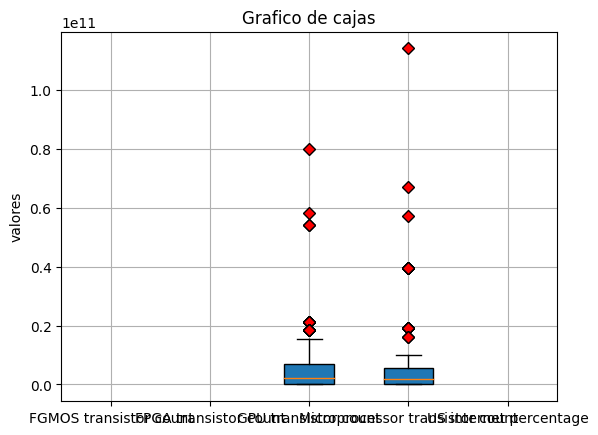

In [368]:
df_numerico = computer_advances.select_dtypes(include = ["float64"])
#
fig, ax1 = plt.subplots(nrows=1, ncols=1)
bplot = ax1.boxplot(
    df_numerico,
    vert=True,
    patch_artist=True,
    labels=df_numerico.columns,
    flierprops=dict(markerfacecolor='r', marker='D')
    )
ax1.set_title('Grafico de cajas')
#
for ax in [ax1]:
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    ax.set_ylabel('valores')
#
plt.show()

Podemos observar los outliers (puntos rojos sobresaliendo de las lineas de valores atipicos), se reemplazar estos utilizando el metodo de z-score.

In [369]:
threshold = 3
for column in df_numerico.columns:
    zscore = np.abs(stats.zscore(computer_advances[column]))
    computer_advances[column] = np.where(zscore > threshold, np.nan, computer_advances[column])
computer_advances = computer_advances.fillna(method='bfill')

### Revisando la economia de Estados Unidos

Los datos generales acerca la economia de los Estados Unidos pueden ser de gran ayuda para normalizar o escalar los datos, por ejemplo no es lo mismo el 1% de la poblacion en el 2005 que ese mismo porcentaje en el 2019, tambien puede ayudarnos el GDP para diferenciar si el crecimiento en una industria esta mas relacionada al crecimiento de la economia en general o si es un crecimiento independiente.

* Poblacion

Este dataset presenta las columnas:
- `Country Name`: nombre del pais.
- `Country Code`: codigo ISO del pais.
- `Indicator Name`: nombre del indicador.
- `Indicator Code`: codigo del indicador.
- `1960, 1961, ..., 2023`: poblacion por año.

Este dataset se procesara de la misma manera que como fue tratado el dataset de Internet.

In [370]:
poblacion = pd.read_csv(f'{DATASETS_FOLDER}/theworldbank_population.csv')
poblacion.tail()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,Unnamed: 66
261,Kosovo,XKX,"Population, total",SP.POP.TOTL,947000.0,966000.0,994000.0,1022000.0,1050000.0,1078000.0,...,1818117.0,1812771.0,1788196.0,1777557.0,1791003.0,1797085.0,1788878.0,1790133.0,1786038.0,NaN
262,"Yemen, Rep.",YEM,"Population, total",SP.POP.TOTL,5542459.0,5646668.0,5753386.0,5860197.0,5973803.0,6097298.0,...,26984002.0,27753304.0,28516545.0,29274002.0,30034389.0,30790513.0,31546691.0,32284046.0,32981641.0,NaN
263,South Africa,ZAF,"Population, total",SP.POP.TOTL,16520441.0,16989464.0,17503133.0,18042215.0,18603097.0,19187194.0,...,53873616.0,54729551.0,55876504.0,56422274.0,56641209.0,57339635.0,58087055.0,58801927.0,59392255.0,NaN
264,Zambia,ZMB,"Population, total",SP.POP.TOTL,3119430.0,3219451.0,3323427.0,3431381.0,3542764.0,3658024.0,...,15234976.0,15737793.0,16248230.0,16767761.0,17298054.0,17835893.0,18380477.0,18927715.0,19473125.0,NaN
265,Zimbabwe,ZWE,"Population, total",SP.POP.TOTL,3806310.0,3925952.0,4049778.0,4177931.0,4310332.0,4447149.0,...,13555422.0,13855753.0,14154937.0,14452704.0,14751101.0,15052184.0,15354608.0,15669666.0,15993524.0,NaN


Poblacion: limpieza del dataset

In [371]:
poblacion = columna_fecha_a_fila(poblacion, 'United States', 'US Population')
poblacion[COLUMNA_FECHA] = pd.to_datetime(poblacion[COLUMNA_FECHA], format='%Y')
poblacion = cortar_agregar_fechas(poblacion)

Poblacion: muestreo del dataset limpio

,Año,US Population
285,2019-10-31,328329953.0
286,2019-11-30,328329953.0
287,2019-12-31,328329953.0
288,2020-01-01,331501080.0
289,2021-01-01,331893745.0


,US Population
count,2.900000e+02
mean,2.970645e+08
std,3.241652e+07
min,1.806710e+08
25%,2.901079e+08
50%,3.054327e+08
75%,3.183863e+08
max,3.318937e+08


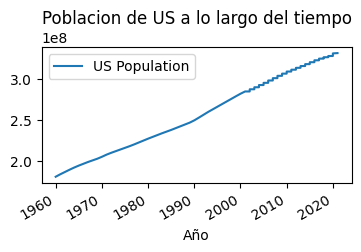

In [372]:
display(poblacion.tail())
display(poblacion.describe())
poblacion.plot(
    x=COLUMNA_FECHA,
    y='US Population',
    title='Poblacion de US a lo largo del tiempo',
    figsize=(4, 2),
    )
plt.show()

* GDP (producto domestico bruto)

Este dataset presenta las columnas:
- `Country Name`: nombre del pais.
- `Country Code`: codigo ISO del pais.
- `Indicator Name`: nombre del indicador.
- `Indicator Code`: codigo del indicador.
- `1960, 1961, ..., 2023`: GDP por año.

Este dataset se procesara de la misma manera que como fue tratado el dataset de Internet.

In [373]:
gdp = pd.read_csv(f'{DATASETS_FOLDER}/theworldbank_gdp.csv')
gdp.tail()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,Unnamed: 66
261,Kosovo,XKX,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,6.735731e+09,7.074658e+09,6.295820e+09,6.682833e+09,7.180813e+09,7.878509e+09,7.899879e+09,7.716925e+09,9.412034e+09,NaN
262,"Yemen, Rep.",YEM,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,4.041523e+10,4.322859e+10,4.244450e+10,3.131783e+10,2.684223e+10,2.160616e+10,NaN,NaN,NaN,NaN
263,South Africa,ZAF,GDP (current US$),NY.GDP.MKTP.CD,8.748597e+09,9.225996e+09,9.813996e+09,1.085420e+10,1.195600e+10,1.306899e+10,...,4.008860e+11,3.811989e+11,3.467098e+11,3.235855e+11,3.814488e+11,4.041597e+11,3.885320e+11,3.376197e+11,4.190150e+11,NaN
264,Zambia,ZMB,GDP (current US$),NY.GDP.MKTP.CD,7.130000e+08,6.962857e+08,6.931429e+08,7.187143e+08,8.394286e+08,1.082857e+09,...,2.803724e+10,2.714102e+10,2.125122e+10,2.095841e+10,2.587360e+10,2.631159e+10,2.330867e+10,1.811063e+10,2.214763e+10,NaN
265,Zimbabwe,ZWE,GDP (current US$),NY.GDP.MKTP.CD,1.052990e+09,1.096647e+09,1.117602e+09,1.159512e+09,1.217138e+09,1.311436e+09,...,1.909102e+10,1.949552e+10,1.996312e+10,2.054868e+10,1.758489e+10,3.415607e+10,2.183223e+10,2.150970e+10,2.837124e+10,NaN


GDP: limpieza del dataset

In [374]:
gdp = columna_fecha_a_fila(gdp, 'United States', 'US GDP')
gdp[COLUMNA_FECHA] = pd.to_datetime(gdp[COLUMNA_FECHA], format='%Y')
gdp = normalizar_con_la_poblacion(gdp, 'US GDP')
gdp = cortar_agregar_fechas(gdp)
gdp = gdp.fillna(method='bfill')

GDP: muestreo del dataset limpio

,Año,US GDP
285,2019-10-31,2.138098e+13
286,2019-11-30,2.138098e+13
287,2019-12-31,2.138098e+13
288,2020-01-01,2.106047e+13
289,2021-01-01,2.331508e+13


,US GDP
count,2.900000e+02
mean,1.391798e+13
std,5.194296e+12
min,5.433000e+11
25%,1.145644e+13
50%,1.462396e+13
75%,1.755068e+13
max,2.331508e+13


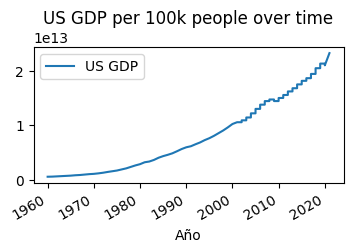

In [375]:
display(gdp.tail())
display(gdp.describe())
gdp.plot(
    x=COLUMNA_FECHA,
    y='US GDP',
    title='US GDP per 100k people over time',
    figsize=(4, 2),
    )
plt.show()

Unificamos todos los datasets procesados y limpios relacionados a la economia, en uno solo

In [376]:
economy = fusionar_por_fecha([gdp, poblacion])
economy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290 entries, 0 to 289
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Año            290 non-null    datetime64[ns]
 1   US GDP         290 non-null    float64       
 2   US Population  290 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 6.9 KB


### Procesando datos relacionado a la industria de los bienes raices

Para analizar esta industria con el mayor de los detalles, se procedera a procesar los datos y almacenar estos resultados en multiples columnas como por ejemplo; "ventas", "inversion", "inversion en propiedades de 1 familia", "inversion en propiedades de 2 familia", etc.

El dataset de bienes raices presenta las siguientes columnas:
- `Date Recorded`: fecha de registro.
- `Sale Amount`: precio al cual se vendio la propiedad en dolares.
- `Property Type`: clasificacion de la propiedad (segun MRC),
- `Residential Type`: clasificacion de la residencia (segun MRC).

Mas informacion acerca la clasificacion de viviendas: [Multifamily residential classification](https://en.wikipedia.org/wiki/Multifamily_residential).

In [377]:
bienes_raices_ventas = pd.read_csv(f'{DATASETS_FOLDER}/real_estate_sales.csv')
bienes_raices_ventas.info()

/tmp/ipykernel_130291/1248722542.py:1: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  bienes_raices_ventas = pd.read_csv(f'{DATASETS_FOLDER}/real_estate_sales.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 997213 entries, 0 to 997212
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Date Recorded     997211 non-null  object 
 1   Sale Amount       997213 non-null  float64
 2   Property Type     614767 non-null  object 
 3   Residential Type  608904 non-null  object 
dtypes: float64(1), object(3)
memory usage: 30.4+ MB


* Limpieza del dataset de bienes raices

In [378]:
bienes_raices_ventas = mantener_columnas(bienes_raices_ventas, [
    'Date Recorded', 'Sale Amount', 'Property Type', 'Residential Type',
    ])
bienes_raices_ventas[COLUMNA_FECHA] = pd.to_datetime(bienes_raices_ventas['Date Recorded'], format='%m/%d/%Y')
bienes_raices_ventas = bienes_raices_ventas.drop(columns=['Date Recorded'])
# Reemplazamos todos los dias por 01 para facilitar agrupar por mes
bienes_raices_ventas[COLUMNA_FECHA] = bienes_raices_ventas[COLUMNA_FECHA].dt.strftime('%Y-%m-01')
# Guardamos el dataset ya "limpio" porque Github no admite archivos mayores a 100MB
if GUARDAR_DATOS_PROCESADOS:
    bienes_raices_ventas.to_csv(f'{DATASETS_FOLDER}/real_estate_sales.csv', index=False)

Bienes raices: muestro del dataset limpio

In [379]:
display(bienes_raices_ventas.tail())
display(bienes_raices_ventas.describe())

,Sale Amount,Property Type,Residential Type,Año
997208,53100.0,Single Family,Single Family,2020-06-01
997209,76000.0,Single Family,Single Family,2019-11-01
997210,210000.0,Single Family,Single Family,2020-04-01
997211,280000.0,Single Family,Single Family,2020-06-01
997212,7450000.0,NaN,NaN,2019-12-01


,Sale Amount
count,9.972130e+05
mean,3.911512e+05
std,5.347270e+06
min,0.000000e+00
25%,1.400000e+05
50%,2.250000e+05
75%,3.650000e+05
max,5.000000e+09


* Calculo de la cantidad de ventas por año

Se agrupara por año la cantidad de propiedades vendidas

In [380]:
# "BR" es un acronimo para Bienes Raices
br_ventas_por_anio = pd.DataFrame()
# Agrupar cantidad de ventas por mes
br_ventas_por_anio[COLUMNA_FECHA] = bienes_raices_ventas[COLUMNA_FECHA]
br_ventas_por_anio['re sales'] = bienes_raices_ventas['Sale Amount']
br_ventas_por_anio = br_ventas_por_anio.groupby(COLUMNA_FECHA).size().reset_index()
br_ventas_por_anio = br_ventas_por_anio.rename(columns={0: 're sales'})
#
br_ventas_por_anio = cortar_agregar_fechas(br_ventas_por_anio)
br_ventas_por_anio = br_ventas_por_anio.fillna(method='bfill')
br_ventas_por_anio = normalizar_con_la_poblacion(br_ventas_por_anio, 're sales')

Muestreo de las ventas por año calculadas

,Año,re sales
466,2021-05-01,5366.0
467,2021-06-01,6623.0
468,2021-07-01,6441.0
469,2021-08-01,6225.0
470,2021-09-01,5683.0


,re sales
count,471.000000
mean,3998.838641
std,1515.717751
min,1.000000
25%,3043.000000
50%,3848.000000
75%,4957.000000
max,8791.000000


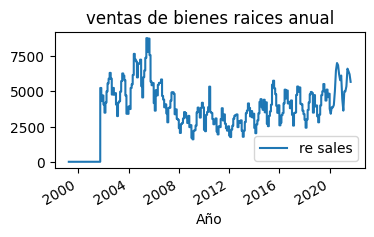

In [381]:
display(br_ventas_por_anio.tail())
display(br_ventas_por_anio.describe())
br_ventas_por_anio.plot(
    x=COLUMNA_FECHA,
    y='re sales',
    title='ventas de bienes raices anual',
    figsize=(4, 2)
    )
plt.show()

* Calculo de la suma de inversiones por año

Se agrupara por año la suma del valor de las propiedades vendidas

In [382]:
br_inversion_por_anio = pd.DataFrame()
# Agrupar cantidad invertida por mes
br_inversion_por_anio[COLUMNA_FECHA] = bienes_raices_ventas[COLUMNA_FECHA]
br_inversion_por_anio['re investment'] = bienes_raices_ventas['Sale Amount']
br_inversion_por_anio = br_inversion_por_anio.groupby(COLUMNA_FECHA).sum().reset_index()
br_inversion_por_anio = br_inversion_por_anio.rename(columns={0: 're investment'})
#
br_inversion_por_anio = cortar_agregar_fechas(br_inversion_por_anio)
br_inversion_por_anio = normalizar_con_la_poblacion(br_inversion_por_anio, 're investment')

Muestreo de las inversiones por año calculadas

,Año,re investment
466,2021-05-01,2.755317e+09
467,2021-06-01,3.522901e+09
468,2021-07-01,4.192108e+09
469,2021-08-01,8.235308e+09
470,2021-09-01,2.745595e+09


,re investment
count,4.710000e+02
mean,1.531054e+09
std,8.128304e+08
min,9.500000e+04
25%,1.072772e+09
50%,1.394021e+09
75%,1.823692e+09
max,8.235308e+09


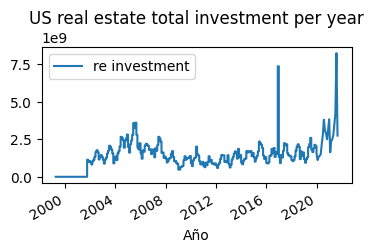

In [383]:
display(br_inversion_por_anio.tail())
display(br_inversion_por_anio.describe())
br_inversion_por_anio.plot(
    x=COLUMNA_FECHA,
    y='re investment',
    title='US real estate total investment per year',
    figsize=(4, 2)
    )
plt.show()

* Calculo de la inversion anual en bienes raices por cada tipo de propiedad y residencia

Se agrupara por cada tipo de propiedad y residencia la suma del valor de las propiedades vendidas anualmente. Podemos observar que poseemos los siguientes tipos de propiedades y residencias:

In [384]:
def obtener_categorias(df:pd.DataFrame, column:str) -> list:
    types = df[column].unique()
    types = [str(x) for x in types]
    return types
def imprimir_categorias(df: pd.DataFrame, column:str) -> None:
    types = obtener_categorias(df, column)
    for i, x in enumerate(types):
        print(f'{i+1}.\t{x}')

Tipos de residencias que tenemos presente en el dataset de bienes raices:

In [385]:
imprimir_categorias(bienes_raices_ventas, 'Residential Type')

1.	nan
2.	Single Family
3.	Condo
4.	Two Family
5.	Three Family
6.	Four Family


Tipos de propiedades que tenemos presente en el dataset de bienes raices:

In [386]:
imprimir_categorias(bienes_raices_ventas, 'Property Type')

1.	Commercial
2.	Residential
3.	Vacant Land
4.	nan
5.	Apartments
6.	Industrial
7.	Public Utility
8.	Condo
9.	Two Family
10.	Three Family
11.	Single Family
12.	Four Family


Procederemos a agrupar las ventas en diferentes categorias y las guardamos en columnas separadas

In [387]:
# Eliminamos tipos de propiedades, las cuales hemos visto mas adelante que presentan muchos valores nulos
def mantener_typos(df:pd.DataFrame, column:str, typos:list) -> pd.DataFrame:
    return df[df[column].isin(typos)]
#
typos_propiedades_a_mantener = [
    'Condo', 'Two Family', 'Three Family',
    'Single Family', 'Four Family',
]
bienes_raices_ventas = mantener_typos(bienes_raices_ventas, 'Property Type', typos_propiedades_a_mantener)
typos_residencias_a_mantener = [
    'Single Family', 'Condo', 'Two Family',
    'Three Family', 'Four Family',
]
bienes_raices_ventas = mantener_typos(bienes_raices_ventas, 'Residential Type', typos_residencias_a_mantener)

def agrupar_por_tipo_por_fecha(df:pd.DataFrame, column:str) -> pd.DataFrame:
    resultado = pd.DataFrame()
    resultado[COLUMNA_FECHA] = bienes_raices_ventas[COLUMNA_FECHA].unique()
    resultado = resultado.sort_values(by=COLUMNA_FECHA).reset_index(drop=True)
    #
    for type in obtener_categorias(df, column):
        new_column_name = f're {type.upper()} investment'
        resultado[new_column_name] = 0
        for year in resultado[COLUMNA_FECHA]:
            sales_amount = df[(df[column] == type) & (df[COLUMNA_FECHA] == year)]['Sale Amount'].sum()
            resultado.loc[resultado[COLUMNA_FECHA] == year, new_column_name] = sales_amount
        ## resultado = normalizar_con_la_poblacion(resultado, new_column_name)
        resultado = resultado.fillna(method='bfill')
    return resultado

property_types_annual = agrupar_por_tipo_por_fecha(bienes_raices_ventas, 'Property Type')
residential_types_annual = agrupar_por_tipo_por_fecha(bienes_raices_ventas, 'Residential Type')

Muestreo del calculo de ventas por cada tipo de propiedad

,Año,re CONDO investment,re TWO FAMILY investment,re THREE FAMILY investment,re SINGLE FAMILY investment,re FOUR FAMILY investment
180,2020-05-01,1.465843e+08,37723926.0,15326388,1.190297e+09,1515500
181,2020-06-01,1.805396e+08,46021780.0,21284078,1.653826e+09,3774000
182,2020-07-01,2.480436e+08,45813184.0,22237925,2.189361e+09,3447000
183,2020-08-01,2.840804e+08,64472836.0,26545590,2.604900e+09,159734200
184,2020-09-01,2.965516e+08,71996794.0,43251371,2.447775e+09,11784500


,re CONDO investment,re TWO FAMILY investment,re THREE FAMILY investment,re SINGLE FAMILY investment,re FOUR FAMILY investment
count,1.850000e+02,1.850000e+02,1.850000e+02,1.850000e+02,1.850000e+02
mean,1.482781e+08,2.841281e+07,1.223526e+07,8.434162e+08,3.652571e+06
std,1.713453e+08,1.488639e+07,7.159105e+06,4.442826e+08,1.177958e+07
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.964680e+07,1.911991e+07,8.017924e+06,5.724845e+08,1.464554e+06
50%,1.405474e+08,2.762643e+07,1.115005e+07,8.565862e+08,2.260000e+06
75%,1.767243e+08,3.772393e+07,1.532639e+07,1.066808e+09,3.472000e+06
max,2.248216e+09,7.199679e+07,4.325137e+07,2.604900e+09,1.597342e+08


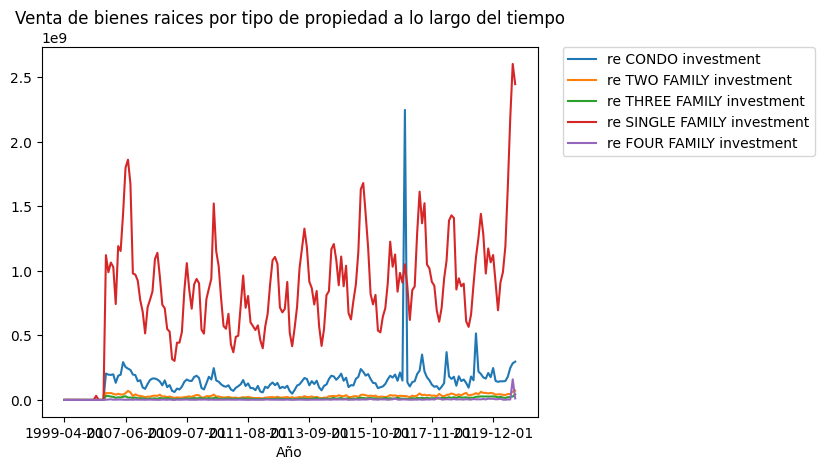

In [388]:
display(property_types_annual.tail())
display(property_types_annual.describe())
property_types_annual.plot(
    x=COLUMNA_FECHA,
    y=property_types_annual.columns[1:],
    title='Venta de bienes raices por tipo de propiedad a lo largo del tiempo',
    )
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

Muestreo del calculo de ventas por cada tipo de residencia

,Año,re CONDO investment,re TWO FAMILY investment,re THREE FAMILY investment,re SINGLE FAMILY investment,re FOUR FAMILY investment
180,2020-05-01,1.465843e+08,37723926.0,15326388,1.190297e+09,1515500
181,2020-06-01,1.805396e+08,46021780.0,21284078,1.653826e+09,3774000
182,2020-07-01,2.480436e+08,45813184.0,22237925,2.189361e+09,3447000
183,2020-08-01,2.840804e+08,64472836.0,26545590,2.604900e+09,159734200
184,2020-09-01,2.965516e+08,71996794.0,43251371,2.447775e+09,11784500


,re CONDO investment,re TWO FAMILY investment,re THREE FAMILY investment,re SINGLE FAMILY investment,re FOUR FAMILY investment
count,1.850000e+02,1.850000e+02,1.850000e+02,1.850000e+02,1.850000e+02
mean,1.482781e+08,2.841281e+07,1.223526e+07,8.434162e+08,3.652571e+06
std,1.713453e+08,1.488639e+07,7.159105e+06,4.442826e+08,1.177958e+07
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.964680e+07,1.911991e+07,8.017924e+06,5.724845e+08,1.464554e+06
50%,1.405474e+08,2.762643e+07,1.115005e+07,8.565862e+08,2.260000e+06
75%,1.767243e+08,3.772393e+07,1.532639e+07,1.066808e+09,3.472000e+06
max,2.248216e+09,7.199679e+07,4.325137e+07,2.604900e+09,1.597342e+08


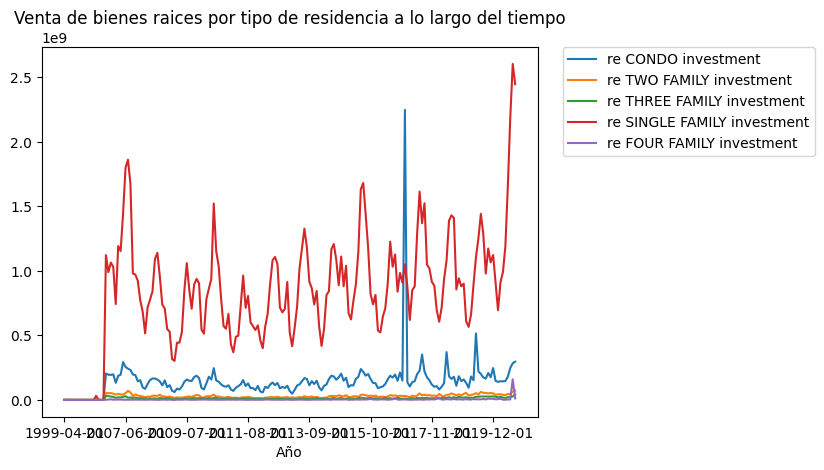

In [389]:
display(residential_types_annual.tail())
display(residential_types_annual.describe())
residential_types_annual.plot(
    x=COLUMNA_FECHA,
    y=residential_types_annual.columns[1:],
    title='Venta de bienes raices por tipo de residencia a lo largo del tiempo',
    )
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

Las ventas de bienes raices residenciales seran descartadas ya que es muy similar a las ventas de propiedades. Realizar el analisis con estos datos serian como duplicar la informacion.

Procederemos a agrupar los diferentes columnas que obtuvimos del procesamiento y las unificamos en un mismo dataset

In [390]:
bienes_raices = fusionar_por_fecha([
    br_ventas_por_anio, property_types_annual, br_inversion_por_anio,
    ])
bienes_raices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471 entries, 0 to 470
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Año                          471 non-null    datetime64[ns]
 1   re sales                     471 non-null    float64       
 2   re CONDO investment          459 non-null    float64       
 3   re TWO FAMILY investment     459 non-null    float64       
 4   re THREE FAMILY investment   459 non-null    float64       
 5   re SINGLE FAMILY investment  459 non-null    float64       
 6   re FOUR FAMILY investment    459 non-null    float64       
 7   re investment                471 non-null    float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 29.6 KB


Procedemos revisar si encontramos outliers en los datos de bienes raices

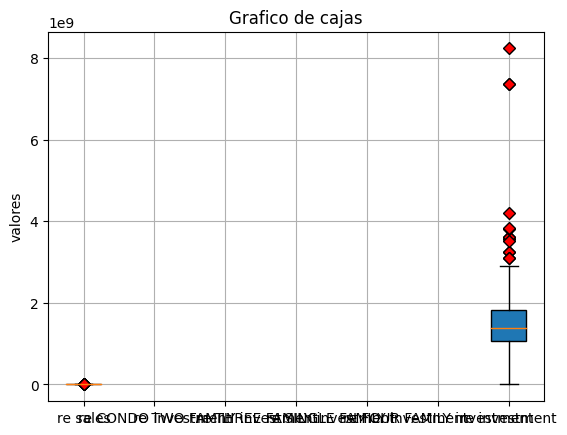

In [391]:
df_numerico = bienes_raices.select_dtypes(include = ["float64"])
#
fig, ax1 = plt.subplots(nrows=1, ncols=1)
bplot = ax1.boxplot(
    df_numerico,
    vert=True,
    patch_artist=True,
    labels=df_numerico.columns,
    flierprops=dict(markerfacecolor='r', marker='D')
    )
ax1.set_title('Grafico de cajas')
#
for ax in [ax1]:
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    ax.set_ylabel('valores')
#
plt.show()

Podemos observar que existen outliers en los datos de bienes raices (puntos rojos), procedemos a remover estos puntos utilizando el metodo de z-score.

In [392]:
threshold = 3
for column in df_numerico.columns:
    zscore = np.abs(stats.zscore(bienes_raices[column]))
    bienes_raices[column] = np.where(zscore > threshold, np.nan, bienes_raices[column])
bienes_raices = bienes_raices.fillna(method='bfill')

### Analizando el impacto de los avances de la computacion en las ventas de bienes raices

A continuacion analizaremos los datos de los avances en computacion y de bienes raices para ver si encontramos alguna correlacion y si logramos poder proyectar alguna regresion.

Ignoraremos las correlaciones que existan entre columnas propias de la computacion o de los bienes raices, es decir por ejemplo: alguna correlacion entre la cantidad de transistores en los Microprocesadores y la cantidad de transistores en las GPU, esto es debido a que solo nos interesa como afecta una industria a otra, no a si misma.

* Unificacion de las columnas de avances en computacion y avances en bienes raices

In [393]:
computacion_y_bienes_raices = fusionar_por_fecha([computer_advances, bienes_raices])
computacion_y_bienes_raices = computacion_y_bienes_raices.fillna(method='bfill')
computacion_y_bienes_raices = cortar_agregar_fechas(computacion_y_bienes_raices)
numeric_df = computacion_y_bienes_raices.select_dtypes(include=['float64', 'int', 'int64'])
columns_to_analize_correlation = numeric_df.columns

* Analizando correlaciones entre la computacion y bienes raices

Procederemos a buscar correlaciones entre las columnas relacionadas a la computacion y las columnas relacionadas a los bienes raices, para ver si es posible proyectar alguna regresion.

/tmp/ipykernel_130291/2886285098.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = computacion_y_bienes_raices.corr(method='pearson')


<Axes: >

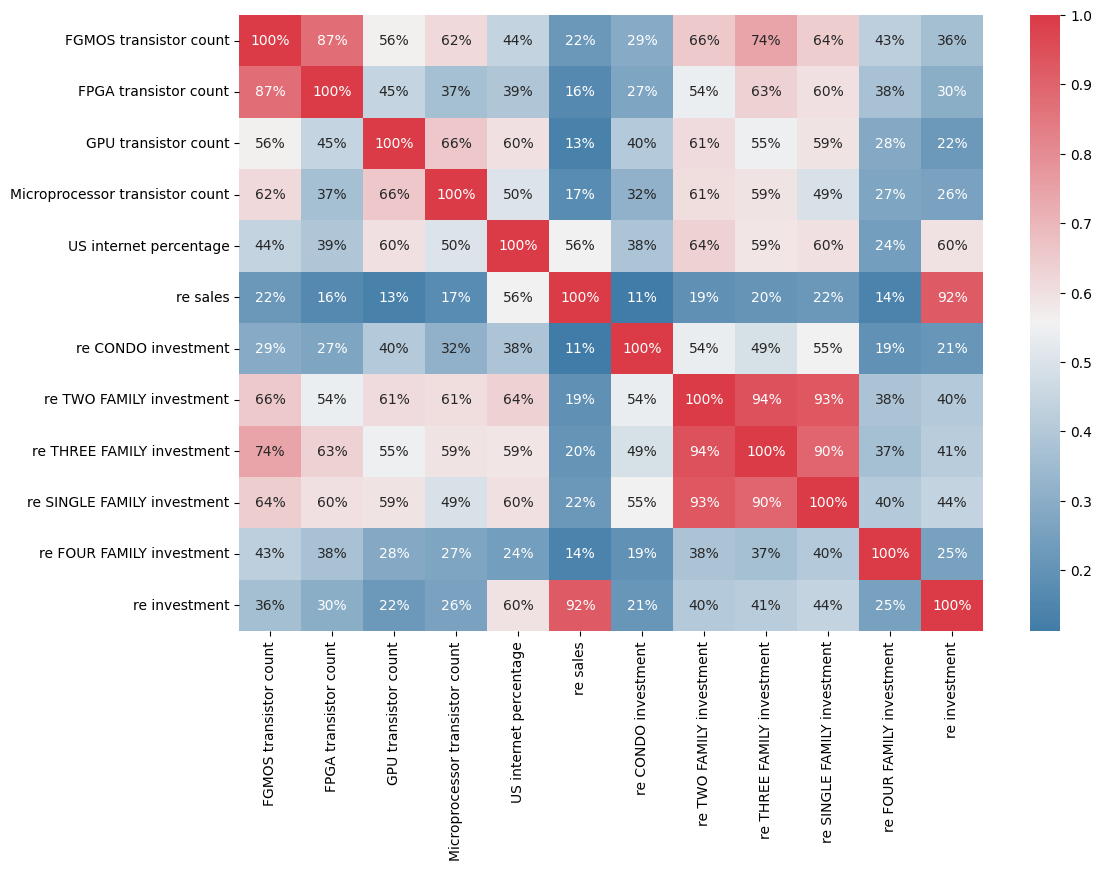

In [394]:
corr = computacion_y_bienes_raices.corr(method='pearson')
plt.subplots(figsize=(12,8))
sns.heatmap(
    corr,
    xticklabels=columns_to_analize_correlation,
    yticklabels=columns_to_analize_correlation,
    annot=True,
    fmt='.0%',
    cmap=sns.diverging_palette(240, 10, as_cmap=True)
    )

Lo primero que se puede observar es que hay una fuerte correlacion interna entre las variables de los bienes raices e internamente entre las variables de la computacion, pero recordemos que estas correlaciones estan fuera de nuestro interes, solo nos interesan aquellas correlaciones directas entre los bienes raices y la computacion.

Entre los bienes raices y la computacion podemos encontrar que `US internet percentage` tiene una correlacion lineal "aceptable" con `re investment`, `re SINGLE FAMILY investment`, `re THREE FAMILY investment` y `re TWO FAMILY investment`.

`FGMOS transistor count` y `GPU transistor count` tambien tiene correlaciones parecidas a internet aunque en menor medida.

Recordemos que 100% o -100% seria una correlacion perfecta y 0% seria una correlacion nula.

Veamos el grafico de pares para ver que tipo de relaciones encontramos entre los datos, estos pueden ser lineales, polinomicas, etc.

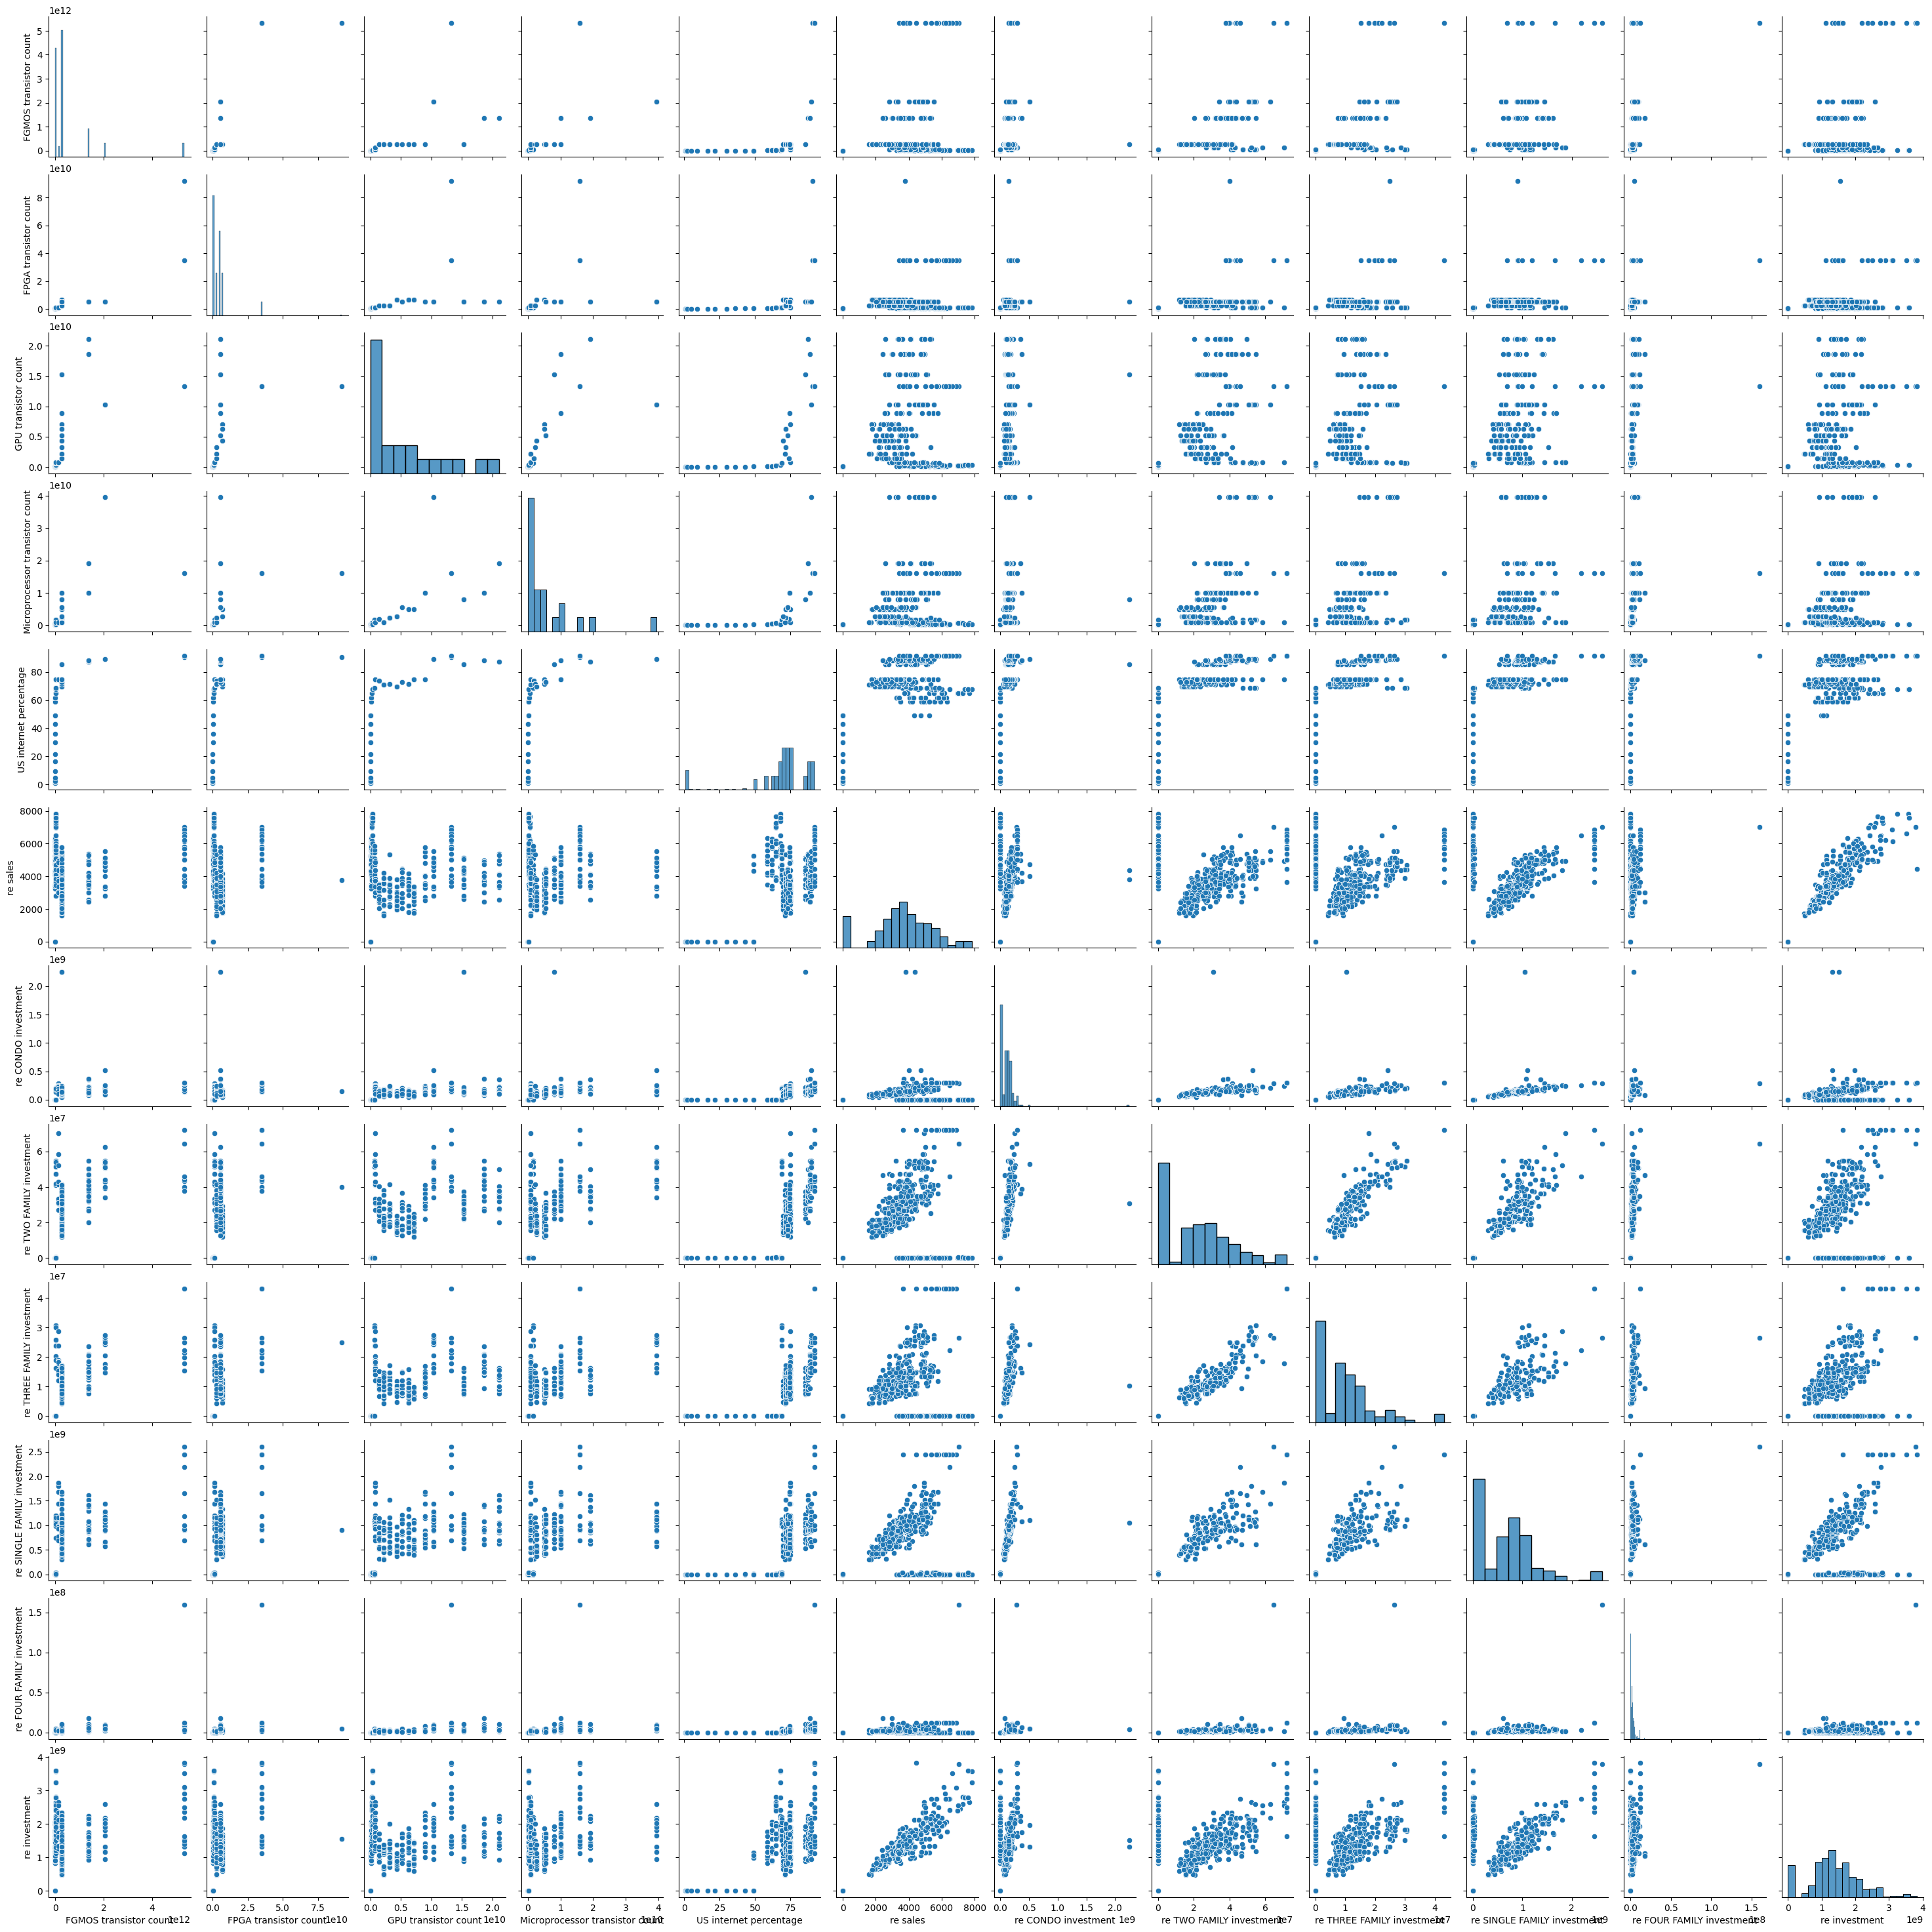

In [395]:
# Quitamos un punto que esta muy alejado del resto, por algun
# motivo no fue removido cuando se aplico el zscore.
computacion_y_bienes_raices = computacion_y_bienes_raices[computacion_y_bienes_raices['re CONDO investment'] < 1.0e9]
#
pp = sns.pairplot(
    numeric_df,
    x_vars=columns_to_analize_correlation,
    y_vars=columns_to_analize_correlation
    )

Podemos encontrar visualmente varias correlaciones tanto lineales como polinomicas 

Tambien podemos ver correlaciones muy claras entre columnas de bienes raices pero recordemos que esas correlaciones estan fuera de nuestra investigacion.

Veamos en detalle algunas correlaciones encontradas en el pairplot e intentemos hacer algunas proyecciones utilizando regresiones.

* Proyectando regresion lineal de "inversion en casas de una familia" con "cantidad de transistores en GPU"

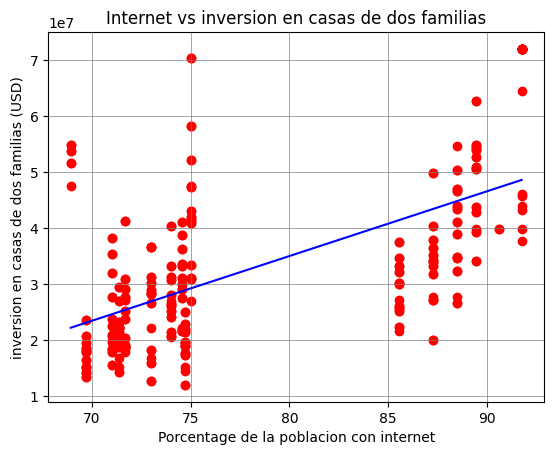

In [396]:
computacion_y_bienes_raices = computacion_y_bienes_raices.dropna()
computacion_y_bienes_raices = computacion_y_bienes_raices[(computacion_y_bienes_raices != 0).all(1)]
#
X = computacion_y_bienes_raices['US internet percentage'].values.reshape(-1,1)
y = computacion_y_bienes_raices['re TWO FAMILY investment'].values.reshape(-1,1)
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
#
plt.scatter(X, y, color = "red")
plt.plot(X, lin_reg.predict(X), color = "blue")
plt.title("Internet vs inversion en casas de dos familias")
plt.xlabel("Porcentage de la poblacion con internet")
plt.ylabel("inversion en casas de dos familias (USD)")
plt.grid(color='gray', linestyle='-', linewidth=0.5)
plt.show()

Analizamos el error de la regresion lineal realizada

In [397]:
y_pred = lin_reg.predict(X_test)
#
def imprimir_error(y, y_test, y_pred) -> None:
    """Imprime el error"""
    valor_medio_y = np.mean(y)
    print('Valor medio Y:', valor_medio_y)
    print('Error Absoluto Medio:', metrics.mean_absolute_error(y_test, y_pred))
    print('Error Cuadratico Medio:', metrics.mean_squared_error(y_test, y_pred))
    raiz_error_cuadratico_medio = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    print('Raíz del error cuadrático medio:', raiz_error_cuadratico_medio)
    print('Porcentaje de error medio: ', (raiz_error_cuadratico_medio / valor_medio_y) * 100, '%')
#
imprimir_error(y, y_test, y_pred)

Valor medio Y: 32567538.174838707
Error Absoluto Medio: 8185483.365339564
Error Cuadratico Medio: 110095246042154.5
Raíz del error cuadrático medio: 10492628.176112717
Porcentaje de error medio:  32.21805750186913 %


Podemos observar que la raiz del error cuadratico medio es del 32.21%, lo que nos indica que la regresion lineal es buena.

* Proyectando regresion polinomica en "Cantidad de transistores en el GPU" vs "ventas de bienes raices"

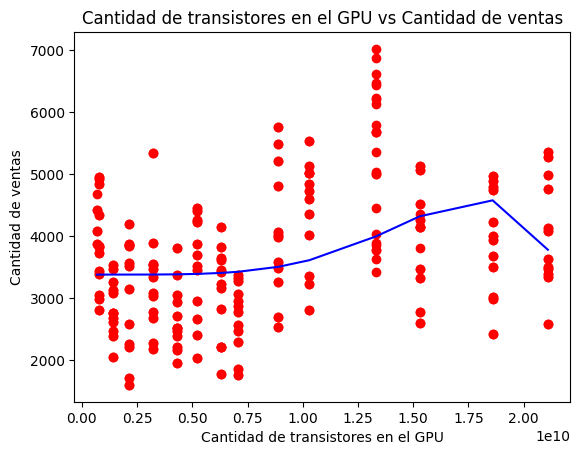

In [398]:
computacion_y_bienes_raices = computacion_y_bienes_raices.dropna()
computacion_y_bienes_raices = computacion_y_bienes_raices.sort_values(by=['GPU transistor count'])
#
y = computacion_y_bienes_raices['re sales'].values.reshape(-1,1)
X = computacion_y_bienes_raices['GPU transistor count'].values.reshape(-1,1)
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#
lin_reg=LinearRegression()
lin_reg.fit(X_train, y_train)
poly_reg=PolynomialFeatures(degree=6)
X_poly=poly_reg.fit_transform(X)
poly_reg.fit(X_poly,y)
lin_reg2=LinearRegression()
lin_reg2.fit(X_poly,y)
#
plt.scatter(X, y, color = "red")
plt.plot(X,lin_reg2.predict(poly_reg.fit_transform(X)),color='blue')
plt.title('Cantidad de transistores en el GPU vs Cantidad de ventas')
plt.xlabel('Cantidad de transistores en el GPU')
plt.ylabel('Cantidad de ventas')
plt.show()

Veamos la precision obtenida con la regresion polinomica

In [399]:
y_pred = lin_reg2.predict(poly_reg.fit_transform(X_test))
imprimir_error(y, y_test, y_pred)

Valor medio Y: 3626.7360703812315
Error Absoluto Medio: 698.6033794945253
Error Cuadratico Medio: 879516.4190160849
Raíz del error cuadrático medio: 937.8253670146083
Porcentaje de error medio:  25.858660481903417 %


Podemos observar que la precision es del 25%, para hacer este tipo de predicciones tambien tenemos a disposicion la regresion con vectores de soporte (SVR). 

Este metodo basicamente intenta minimizar la tasa de error dentro de un cierto umbral (limites de decision).

Probemos de utilizar SVR para ver si podemos obtener una mejor precision

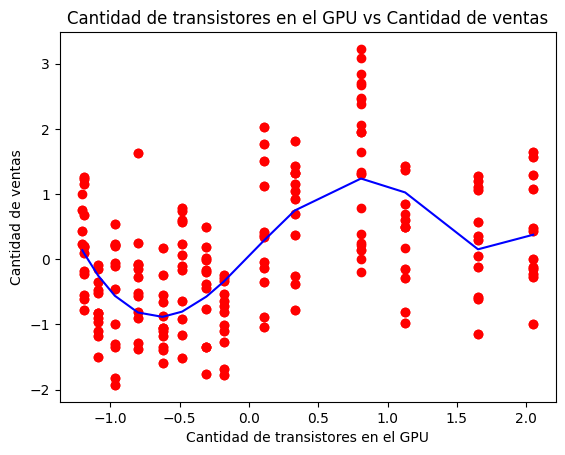

In [408]:
computacion_y_bienes_raices = computacion_y_bienes_raices.dropna()
computacion_y_bienes_raices = computacion_y_bienes_raices.sort_values(by=['GPU transistor count'])
#
y = computacion_y_bienes_raices['re sales'].values.reshape(-1,1)
X = computacion_y_bienes_raices['GPU transistor count'].values.reshape(-1,1)
#
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y.reshape(-1,1))
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#
svr_poly = SVR(kernel="poly", C=100, gamma="auto", degree=5, epsilon=0.1, coef0=1)
svr_poly.fit(X_train, y_train.ravel())
#
plt.scatter(X, y, color = "red")
plt.plot(X, svr_poly.predict(X), color = "blue")
plt.title('Cantidad de transistores en el GPU vs Cantidad de ventas')
plt.xlabel('Cantidad de transistores en el GPU')
plt.ylabel('Cantidad de ventas')
plt.show()

Podemos observar a simple vista que se adapto mejor SVR que utilizando la regresion polinomica, veamos el error de la regresion realizada

In [409]:
y_pred = svr_poly.predict(X_test)
imprimir_error(y, y_test, y_pred)

Valor medio Y: 2.2920733411616134e-16
Error Absoluto Medio: 0.6977810982267837
Error Cuadratico Medio: 0.701886153732544
Raíz del error cuadrático medio: 0.8377864607001858
Porcentaje de error medio:  3.65514682996836e+17 %


Podemos observar que el error cuadratico medio fue muchisimo mas grande que el obtenido anteriormente con la regresion polinomica.

Hasta ahora hemos podido observar con el analisis de las correlaciones y las regresiones, algunos avances en la computacion estan un poco correlacionados con los bienes raices, lo que indica que de alguna estos avances han tenido un impacto aunque sea minimo.

Ahora veamos cuanto han impactado cada una de todos los avances aplicando una regresion lineal multiple y analizando los coeficientes de cada una de las columnas.

* Analizando cuanto fue el impacto en la INVERSION de bienes raices aplicando una regresion lineal multiple

In [ ]:
computacion_y_bienes_raices = computacion_y_bienes_raices.dropna()
#
df = computacion_y_bienes_raices
df = df.dropna()
#
X = mantener_columnas(
    df,
    df.columns[1:-1].tolist()
    )
y = df['re investment'].values
# Removemos nan values
X = X[~np.isnan(X)]
y = y[~np.isnan(y)]
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
regressor = LinearRegression()
regressor.fit(X_train, y_train)
df = df.drop(columns=['re investment', COLUMNA_FECHA], axis=1)
df = df.T
df = df.index
coeff_df = pd.DataFrame(regressor.coef_, df, columns=['Coefficient'])
coeff_df

,Coefficient
FGMOS transistor count,-7.941097e-05
FPGA transistor count,4.170304e-03
GPU transistor count,-1.131109e-02
Microprocessor transistor count,-8.597455e-05
US internet percentage,1.163154e+07
re sales,3.242914e+05
re CONDO investment,-5.651820e-01
re TWO FAMILY investment,4.149940e-01
re THREE FAMILY investment,6.214715e+00
re SINGLE FAMILY investment,4.509572e-01


Calculamos el error

In [ ]:
y_pred = regressor.predict(X_test)
imprimir_error(y, y_test, y_pred)

Valor medio Y: 1444213667.1520233
Error Absoluto Medio: 130720147.4548964
Error Cuadratico Medio: 2.638992400642076e+16
Raíz del error cuadrático medio: 162449758.4067787
Porcentaje de error medio:  11.248318867327173 %


Podemos observar que obtuvimos una raiz del error cuadratico es medio muy alto con respecto al valor medio Y (11%) aunque sigue siendo aceptable.

De estos coeficientes podemos observar que por cada porcentaje de la poblacion con acceso a internet, la inversion en bienes raices aumenta 1.16x10^7 USD.

* Analizando el impacto en las VENTAS de bienes raices aplicando una regresion lineal multiple

In [ ]:
computacion_y_bienes_raices = computacion_y_bienes_raices.dropna()
#
df = computacion_y_bienes_raices
df = df.dropna()
#
X = mantener_columnas(
    df,
    df.columns[1:-1].tolist()
    )
y = df['re sales'].values
# removemos nan values
X = X[~np.isnan(X)]
y = y[~np.isnan(y)]
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
regressor = LinearRegression()
regressor.fit(X_train, y_train)
df = df.drop(columns=['re sales', COLUMNA_FECHA], axis=1)
df = df.T
df = df.index
coeff_df = pd.DataFrame(regressor.coef_, df, columns=['Coefficient'])
coeff_df

,Coefficient
FGMOS transistor count,-2.360977e-21
FPGA transistor count,-6.501640e-20
GPU transistor count,-4.131320e-19
Microprocessor transistor count,2.490806e-20
US internet percentage,5.940007e-10
re CONDO investment,1.000000e+00
re TWO FAMILY investment,-3.177873e-17
re THREE FAMILY investment,-6.040222e-16
re SINGLE FAMILY investment,4.535342e-16
re FOUR FAMILY investment,1.268889e-17


Calculamos el error

In [ ]:
y_pred = regressor.predict(X_test)
imprimir_error(y, y_test, y_pred)

Valor medio Y: 3626.7360703812315
Error Absoluto Medio: 3.0731727114787486e-09
Error Cuadratico Medio: 1.522962033313878e-17
Raíz del error cuadrático medio: 3.902514616646398e-09
Porcentaje de error medio:  1.0760404233761012e-10 %


Podemos ver que la raiz de error cuadratico medio es bastante (sospechosamente) bajo comparandolo con el valor medio de Y, lo que nos dice que los coeficientes de la regresion lineal multiple son bastante acertados, pero tambien este error excesivamente bajo puede deberse a que la cantidad de datos que quizas puede ser pequeña.

De esta ultima regresion lineal multiple, podemos observar que por cada % de poblacion que utiliza internet, las ventas de bienes raices se incrementan un 5.94e-10, practicamente 0 lo que podemos decir que no impacto en la cantidad de ventas directamente.

### Conclusion

En esta investigacion hemos podido observar que los avances en la computacion y los bienes raices tienen algunas correlaciones, hemos podido proyectar regresiones lineales, polinomicas y calcular mediante regresiones lineales multiples cual es el coeficiente con el cual impacta cada avance computacional en las ventas e inversion de bienes raices.

Observamos que el avance en memorias flash y GPUs son las que tienen las mejores correlaciones, y hemos podido observar mediante las regresiones lineales multiples, que el internet es la tecnologia que mas peso tuvo en las inversiones de bienes raices (1.2x10^9 USD por % de poblacion con internet) pero sin embargo, no afecto tanto a las ventas (4.339115e-08 ventas, cero practicamente).

Pero sin embargo se debe tener en cuenta que la industria de bienes raices fue altamente afectada por la burbuja del 2008, por lo cual esto pudo afectar gravemente nuestra investigacion.

### Referencias

1. Transistor count datasets (extraido de las tablas) https://en.wikipedia.org/wiki/Transistor_count
1. World Bank Data https://data.worldbank.org/
1. DATA.GOV registros de ventas https://catalog.data.gov/dataset/real-estate-sales-2001-2018
1. Sistema de clasificacion multifamiliar https://en.wikipedia.org/wiki/Multifamily_residential